In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from pathlib import Path
import os
import numpy as np
import random

# Adjust this to your dataset location
RAW_ROOT = Path("/kaggle/input/multi-cancer")  # or "data/raw/multi_cancer"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def collect_leaf_dirs(root: Path):
    """Treat each leaf folder as one class."""
    subclass_to_files = {}

    for r, dirs, files in os.walk(root):
        if not files:
            continue

        rpath = Path(r)
        img_files = [
            str(rpath / f)
            for f in files
            if Path(f).suffix.lower() in IMG_EXTS
        ]
        if not img_files:
            continue

        class_name = rpath.name  # leaf folder
        subclass_to_files.setdefault(class_name, []).extend(img_files)

    return subclass_to_files

subclass_to_files = collect_leaf_dirs(RAW_ROOT)

# 26-class mapping
class_names = sorted(subclass_to_files.keys())
class_to_idx = {c:i for i, c in enumerate(class_names)}

# Flatten to X (paths) and y (int labels)
all_paths = []
all_labels = []

for cls_name, paths in subclass_to_files.items():
    idx = class_to_idx[cls_name]
    for p in paths:
        all_paths.append(p)
        all_labels.append(idx)

all_paths  = np.array(all_paths)
all_labels = np.array(all_labels, dtype=np.int32)

len(class_names), len(all_paths)

(26, 130002)

In [3]:
RATIOS = (0.7, 0.15, 0.15)  # train, val, test

train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

for cls, paths in subclass_to_files.items():
    paths = list(paths)
    random.shuffle(paths)
    n = len(paths)
    n_tr  = int(RATIOS[0] * n)
    n_val = int(RATIOS[1] * n)
    n_te  = n - n_tr - n_val

    idx = class_to_idx[cls]

    train_paths += paths[:n_tr]
    val_paths   += paths[n_tr:n_tr+n_val]
    test_paths  += paths[n_tr+n_val:]

    train_labels += [idx] * n_tr
    val_labels   += [idx] * n_val
    test_labels  += [idx] * n_te

train_paths = np.array(train_paths)
val_paths   = np.array(val_paths)
test_paths  = np.array(test_paths)

train_labels = np.array(train_labels, dtype=np.int32)
val_labels   = np.array(val_labels, dtype=np.int32)
test_labels  = np.array(test_labels, dtype=np.int32)

len(train_paths), len(val_paths), len(test_paths)


(91000, 19500, 19502)

In [4]:
import collections

print("Train:", collections.Counter(train_labels))
print("Val  :", collections.Counter(val_labels))
print("Test :", collections.Counter(test_labels))

Train: Counter({10: 3500, 9: 3500, 12: 3500, 13: 3500, 11: 3500, 15: 3500, 14: 3500, 18: 3500, 19: 3500, 20: 3500, 25: 3500, 24: 3500, 3: 3500, 0: 3500, 1: 3500, 2: 3500, 17: 3500, 16: 3500, 7: 3500, 8: 3500, 22: 3500, 21: 3500, 23: 3500, 6: 3500, 4: 3500, 5: 3500})
Val  : Counter({10: 750, 9: 750, 12: 750, 13: 750, 11: 750, 15: 750, 14: 750, 18: 750, 19: 750, 20: 750, 25: 750, 24: 750, 3: 750, 0: 750, 1: 750, 2: 750, 17: 750, 16: 750, 7: 750, 8: 750, 22: 750, 21: 750, 23: 750, 6: 750, 4: 750, 5: 750})
Test : Counter({25: 751, 24: 751, 10: 750, 9: 750, 12: 750, 13: 750, 11: 750, 15: 750, 14: 750, 18: 750, 19: 750, 20: 750, 3: 750, 0: 750, 1: 750, 2: 750, 17: 750, 16: 750, 7: 750, 8: 750, 22: 750, 21: 750, 23: 750, 6: 750, 4: 750, 5: 750})


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(class_names)

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# -------------------------------
# Transform (same as your TF preprocess)
# -------------------------------
transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),              # converts to float + normalizes to [0,1]
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# -------------------------------
# Custom Dataset
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]        # already integer (sparse)

        img = Image.open(path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label

# -------------------------------
# Create datasets
# -------------------------------
train_dataset = ImageDataset(train_paths, train_labels, transform)
val_dataset   = ImageDataset(val_paths,   val_labels,   transform)
test_dataset  = ImageDataset(test_paths,  test_labels,  transform)

print("len(train_paths):", len(train_paths))
print("len(val_paths):", len(val_paths))
print("len(test_paths):", len(test_paths))

len(train_paths): 91000
len(val_paths): 19500
len(test_paths): 19502


In [6]:
# -------------------------------
# DataLoaders
# -------------------------------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [7]:
# !pip install -q timm
# !pip -q install tqdm
from tqdm import tqdm

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# VIT
# ---------------------------
vit_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=NUM_CLASSES
)

# for p in vit_model.parameters():
#     p.requires_grad = False

# for p in vit_model.head.parameters():
#     p.requires_grad = True

vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.head.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [9]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Train", leave=True)
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=total_loss/total, acc=correct/total)

    return total_loss / total, correct / total


In [10]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Val", leave=False)
    with torch.no_grad():
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device).long()

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix(loss=total_loss/total, acc=correct/total)

    return total_loss / total, correct / total


In [11]:
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(vit_model, train_loader, optimizer, criterion)
    val_loss, val_acc     = evaluate(vit_model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10


Train: 100%|██████████| 2844/2844 [44:21<00:00,  1.07it/s, acc=0.854, loss=0.503]


Train Loss: 0.5032 | Train Acc: 0.8542 || Val Loss: 0.2322 | Val Acc: 0.9305

Epoch 2/10


Train: 100%|██████████| 2844/2844 [36:53<00:00,  1.28it/s, acc=0.942, loss=0.188]


Train Loss: 0.1883 | Train Acc: 0.9415 || Val Loss: 0.1612 | Val Acc: 0.9476

Epoch 3/10


Train: 100%|██████████| 2844/2844 [36:27<00:00,  1.30it/s, acc=0.955, loss=0.14]


Train Loss: 0.1405 | Train Acc: 0.9554 || Val Loss: 0.1313 | Val Acc: 0.9566

Epoch 4/10


Train: 100%|██████████| 2844/2844 [36:59<00:00,  1.28it/s, acc=0.963, loss=0.116]


Train Loss: 0.1162 | Train Acc: 0.9630 || Val Loss: 0.1177 | Val Acc: 0.9600

Epoch 5/10


Train: 100%|██████████| 2844/2844 [37:02<00:00,  1.28it/s, acc=0.968, loss=0.101]


Train Loss: 0.1014 | Train Acc: 0.9679 || Val Loss: 0.1052 | Val Acc: 0.9636

Epoch 6/10


Train: 100%|██████████| 2844/2844 [37:00<00:00,  1.28it/s, acc=0.971, loss=0.0907]


Train Loss: 0.0907 | Train Acc: 0.9711 || Val Loss: 0.0977 | Val Acc: 0.9664

Epoch 7/10


Train: 100%|██████████| 2844/2844 [37:26<00:00,  1.27it/s, acc=0.974, loss=0.0829]


Train Loss: 0.0829 | Train Acc: 0.9740 || Val Loss: 0.0890 | Val Acc: 0.9706

Epoch 8/10


Train: 100%|██████████| 2844/2844 [37:07<00:00,  1.28it/s, acc=0.976, loss=0.0767]


Train Loss: 0.0767 | Train Acc: 0.9757 || Val Loss: 0.0845 | Val Acc: 0.9711

Epoch 9/10


Train: 100%|██████████| 2844/2844 [37:27<00:00,  1.27it/s, acc=0.977, loss=0.0717]


Train Loss: 0.0717 | Train Acc: 0.9774 || Val Loss: 0.0818 | Val Acc: 0.9717

Epoch 10/10


Train: 100%|██████████| 2844/2844 [37:12<00:00,  1.27it/s, acc=0.979, loss=0.0674]
                                                                             

Train Loss: 0.0674 | Train Acc: 0.9792 || Val Loss: 0.0790 | Val Acc: 0.9721


In [12]:
save_path = "vit.pth"
torch.save(vit_model.state_dict(), save_path)
print("Saved to:", save_path)

Saved to: vit.pth


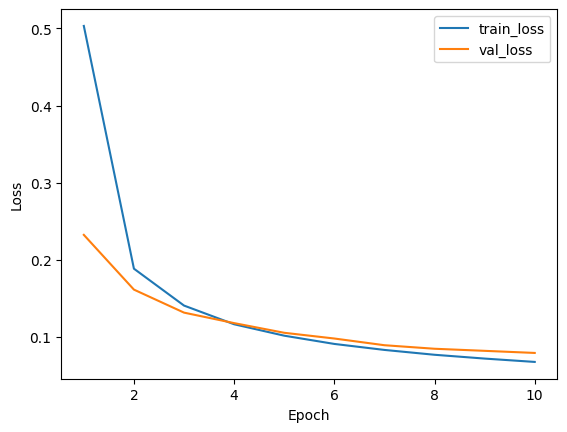

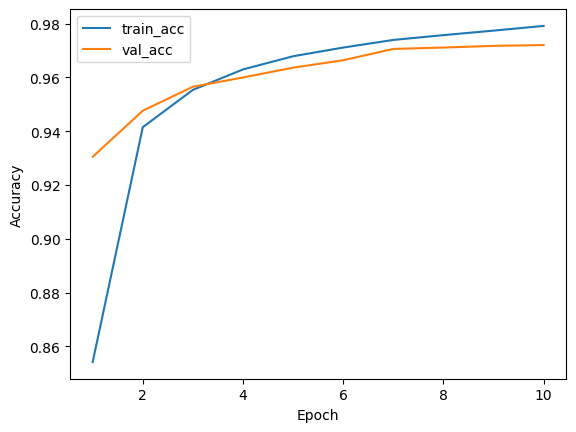

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [14]:
import json

with open("history.json", "w") as f:
    json.dump(history, f)

In [15]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# vit_model = timm.create_model(
#     "vit_base_patch16_224",
#     pretrained=False,          # weight backbone akan kamu load dari file
#     num_classes=NUM_CLASSES
# ).to(device)

# vit_model.load_state_dict(torch.load("vit_leaf_head_only.pth", map_location=device))
# vit_model.eval()
# print("Loaded!")
